# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

<h4>Business Understanding - Technical requirements</h4>
<p>For this business use case we will use the excel sheet in the data folder clean up the data convert certrain columns to fix any data type issues. Build some new columns with calculated columns, remove certain columns that have either too much null values or values that are not going to contribuete towards building the model like VIN numbers etc.</p>
<p>After data clean is completed model will be created and validated to validate they work with the data and evaluation will be provided as to which factors influence the price most.  </p>

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1]:
# importing modules

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [2]:
# reading file, creating dataframe
df = pd.read_csv('data/vehicles.csv')


In [3]:
# Gathering info ont he data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
# Gathering more info with describe
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [5]:
# Checking for duplicate values in the id column
duplicate_ids = df['id'].duplicated().sum()

duplicate_ids

0

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [6]:
# Converting year and odometer to Int64 type
df['year'] = df['year'].astype('Int64')
df['odometer'] = df['odometer'].astype('Int64')


In [7]:
# Was using this (#df = df.dropna(subset=['year', 'manufacturer', 'model', 'odometer']))  to drop NA originally but ended up taking about an hour or so to run the training modeling and MSE 
# So moving to drop all NA values to make it feasible to run. 
df = df.dropna()

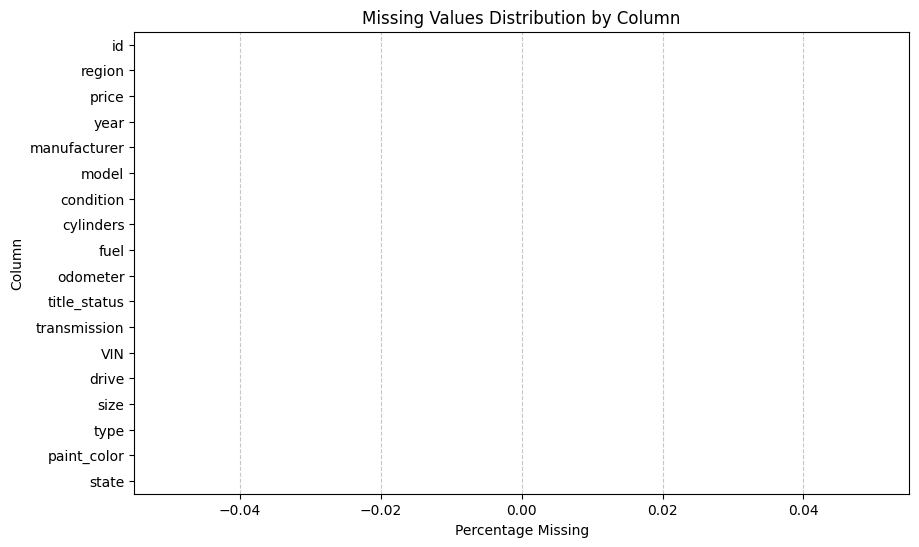

In [8]:
# Summary of missing values for each column
missing_values_summary = df.isnull().sum().reset_index()
missing_values_summary.columns = ['Column', 'Missing Values']
missing_values_summary['Percentage Missing'] = (missing_values_summary['Missing Values'] / len(df)) * 100

# Plotting the distribution of missing values
plt.figure(figsize=(10, 6))
sns.barplot(x='Percentage Missing', y='Column', data=missing_values_summary)
plt.xlabel('Percentage Missing')
plt.title('Missing Values Distribution by Column')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [9]:
# Understanding the current year and then recalculating a new column car_age from the column year.
current_year = datetime.now().year

df.loc[:, 'car_age'] = current_year - df['year']

df[['year', 'car_age']]

,year,car_age
126,2018,6
127,2019,5
128,2018,6
215,2002,22
219,1995,29
...,...,...
426788,2016,8
426792,2014,10
426793,2018,6
426833,1997,27


In [10]:
# Dropping 3 columns that are not required to predict the prices.
df.drop(['VIN', 'size','year'], axis=1, inplace=True)

In [11]:
# validating the dataframe
df

,id,region,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,car_age
126,7305672709,auburn,0,chevrolet,express cargo van,like new,6 cylinders,gas,68472,clean,automatic,rwd,van,white,al,6
127,7305672266,auburn,0,chevrolet,express cargo van,like new,6 cylinders,gas,69125,clean,automatic,rwd,van,white,al,5
128,7305672252,auburn,0,chevrolet,express cargo van,like new,6 cylinders,gas,66555,clean,automatic,rwd,van,white,al,6
215,7316482063,birmingham,4000,toyota,echo,excellent,4 cylinders,gas,155000,clean,automatic,fwd,sedan,blue,al,22
219,7316429417,birmingham,2500,bmw,525i,fair,6 cylinders,gas,110661,clean,automatic,rwd,sedan,white,al,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426788,7303227528,wyoming,12995,chevrolet,cruze lt,like new,4 cylinders,gas,61127,clean,automatic,fwd,sedan,silver,wy,8
426792,7303114896,wyoming,32999,ford,"f350, xlt",excellent,8 cylinders,diesel,154642,clean,automatic,4wd,pickup,brown,wy,10
426793,7303112347,wyoming,15999,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465,clean,automatic,fwd,sedan,black,wy,6
426833,7302338378,wyoming,6800,jaguar,xk8 convertible,good,8 cylinders,gas,69550,clean,automatic,rwd,convertible,white,wy,27


In [12]:
# Checking for outliers on price, family sales, title transfers etc
prices_under_100_count = df[(df['price'] < 51)].shape[0]
print(prices_under_100_count)


df = df[df['price'] > 50]
df.reset_index(drop=True, inplace=True)
df

3066


,id,region,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,car_age
0,7316482063,birmingham,4000,toyota,echo,excellent,4 cylinders,gas,155000,clean,automatic,fwd,sedan,blue,al,22
1,7316429417,birmingham,2500,bmw,525i,fair,6 cylinders,gas,110661,clean,automatic,rwd,sedan,white,al,29
2,7315946365,birmingham,9000,mazda,miata mx-5,excellent,4 cylinders,gas,56700,clean,automatic,rwd,convertible,white,al,16
3,7315354216,birmingham,8950,ford,f-150,excellent,6 cylinders,gas,164000,clean,automatic,fwd,truck,white,al,13
4,7315349921,birmingham,4000,mercedes-benz,benz,fair,6 cylinders,gas,88100,clean,automatic,rwd,coupe,silver,al,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31797,7303314912,wyoming,23495,ford,f150 xlt 4x4,like new,8 cylinders,gas,146795,clean,automatic,4wd,truck,black,wy,9
31798,7303227528,wyoming,12995,chevrolet,cruze lt,like new,4 cylinders,gas,61127,clean,automatic,fwd,sedan,silver,wy,8
31799,7303114896,wyoming,32999,ford,"f350, xlt",excellent,8 cylinders,diesel,154642,clean,automatic,4wd,pickup,brown,wy,10
31800,7303112347,wyoming,15999,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465,clean,automatic,fwd,sedan,black,wy,6


In [13]:
# Filter the dataframe to remove rows where the price is greater than 550000 odometer higher than 550000 to remove outliers for price and odometer
df = df[df['price'] <= 550000]
df = df[df['odometer'] <= 550000]


In [14]:
#Validating all prices below 51 are no longer in the dataframe
prices_under_100_count = df[(df['price'] < 51)].shape[0]
print(prices_under_100_count)

0


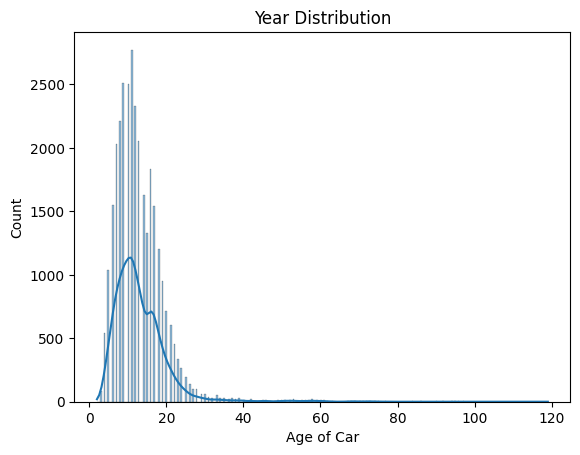

In [15]:
# Distribution of age of car
sns.histplot(df['car_age'], kde=True)
plt.title('Year Distribution')
plt.xlabel('Age of Car')
plt.show()



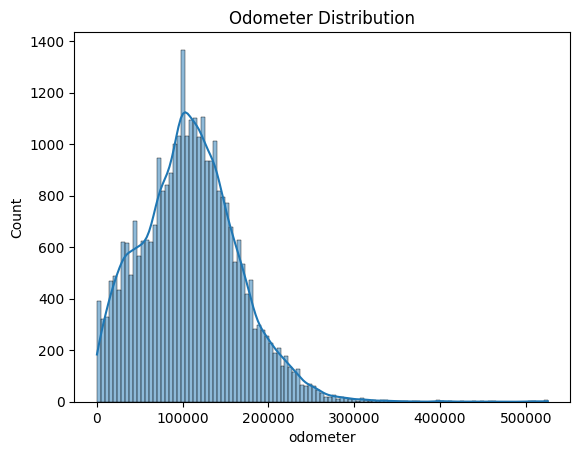

In [16]:
# Distribution of odometer readings
sns.histplot(df['odometer'], kde=True)
plt.title('Odometer Distribution')
plt.show()

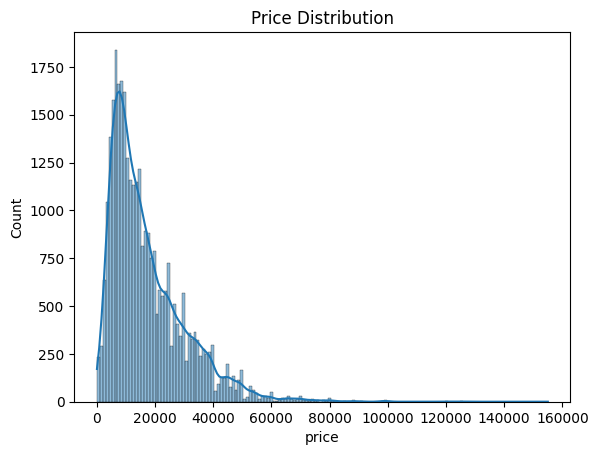

In [17]:
# Distribution of price
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution')
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [18]:
# Select relevant features and target
features = ['car_age', 'manufacturer', 'model', 'odometer', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'state']
target = 'price'

# Separate features (X) and target (y)
X = df[features]
y = df[target]

In [19]:
# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)


In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [21]:
# Ridge  Regression
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

Ridge()

In [22]:
# Make predictions on the test set
y_pred = ridge_model.predict(X_test)

In [23]:
# Mean Squared error calculation
mse_ridge = mean_squared_error(y_test, y_pred)

# Calculating Mean Squared Error (MSE)
mse_ridge = mean_squared_error(y_test, y_pred)

# Calculating Root Mean Squared Error (RMSE)
rmse_ridge = np.sqrt(mse_ridge)

# Calculating Mean Absolute Error (MAE)
mae_ridge = mean_absolute_error(y_test, y_pred)

# Calculating R-squared (R^2)
r_squared_ridge = r2_score(y_test, y_pred)

# Display the results
print(f"Ridge Mean Squared error is:{mse_ridge:.4f}")
print(f"Ridge Root Mean Squared error is:{rmse_ridge:.4f}")
print(f"Ridge Mean Absolute Error is:{mae_ridge:.4f}")
print(f"Ridge R-squaredr is:{r_squared_ridge:.4f}")

Ridge Mean Squared error is:46040859.9305
Ridge Root Mean Squared error is:6785.3415
Ridge Mean Absolute Error is:4072.3775
Ridge R-squaredr is:0.7351


In [24]:
# Train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_linear = linear_model.predict(X_test)

# Calculating Mean Squared Error (MSE)
mse_linear = mean_squared_error(y_test, y_pred_linear)

# Calculating Root Mean Squared Error (RMSE)
rmse_linear = np.sqrt(mse_linear)

# Calculating Mean Absolute Error (MAE)
mae_linear = mean_absolute_error(y_test, y_pred_linear)

# Calculating R-squared (R^2)
r_squared_linear = r2_score(y_test, y_pred_linear)

# Display the results
print(f"Linear Mean Squared error is:{mse_linear:.4f}")
print(f"Linear Root Mean Squared error is:{rmse_linear:.4f}")
print(f"Linear Mean Absolute Error is:{mae_linear:.4f}")
print(f"Linear R-squaredr is:{r_squared_linear:.4f}")

Linear Mean Squared error is:52034582.0039
Linear Root Mean Squared error is:7213.5000
Linear Mean Absolute Error is:4088.2967
Linear R-squaredr is:0.7006


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [25]:
# Ridge Regression (L2)
ridge_model = Ridge(alpha=100)  
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)


ridge_mse

58468635.442195825

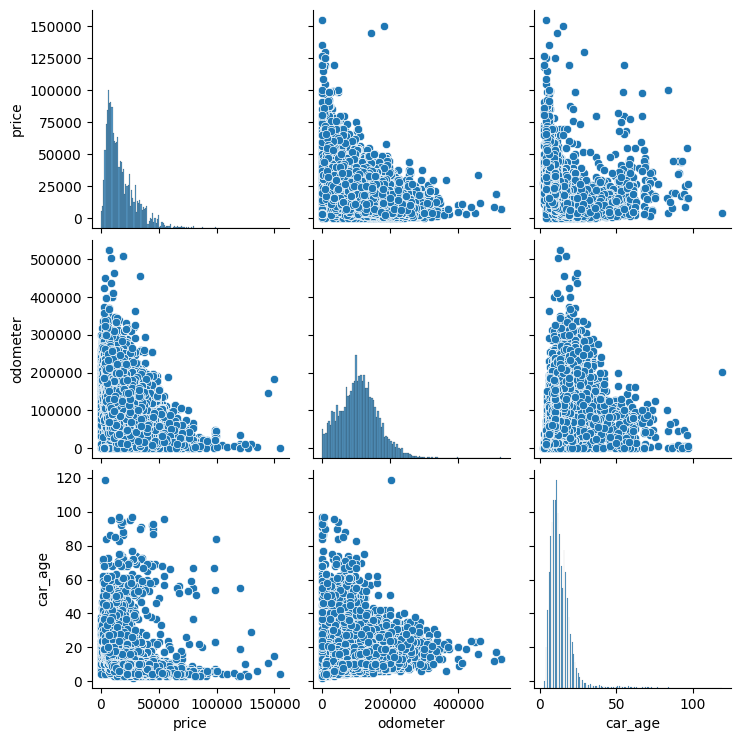

In [26]:
# Select numerical columns for plotting
numerical_cols = ['price', 'odometer', 'car_age']

# Create pairplot to visualize the relationships
sns.pairplot(df[numerical_cols])
plt.show()

In [27]:
# Train the Ridge Regression model
ridge_model = Ridge(alpha=100)  
ridge_model.fit(X_train, y_train)

# Get the coefficients of the features
ridge_coefficients = pd.Series(ridge_model.coef_, index=X_train.columns)

# Sort the coefficients by importance (absolute value)
ridge_feature_importance = ridge_coefficients.abs().sort_values(ascending=False)

# Display the feature importance
print("Feature Importance from Ridge Regression:")
ridge_feature_importance

Feature Importance from Ridge Regression:


fuel_gas                       11690.565397
fuel_hybrid                     7927.220684
manufacturer_porsche            6073.545549
drive_fwd                       5908.585534
manufacturer_ferrari            5437.240103
                                   ...     
model_tiguan se awd 4motion        0.000000
model_f450 sd xl                   0.000000
model_tiguan sel 4motion           0.000000
model_c/k 10                       0.000000
model_mariner luxury               0.000000
Length: 5042, dtype: float64

In [28]:
# Seeing confusing results from the above ridge regression feature importance testing with RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest Regressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Get feature importance
rf_feature_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Display feature importance
rf_feature_importance

car_age                        0.328608
odometer                       0.129548
cylinders_4 cylinders          0.122327
fuel_gas                       0.099195
drive_fwd                      0.058602
                                 ...   
model_corvette stingray 3lt    0.000000
model_3 series 330i sedan      0.000000
model_astro passenger          0.000000
model_sierra crew cab 4wd      0.000000
model_ioniq hybrid             0.000000
Length: 5042, dtype: float64

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

<h3>Recommendation</h3>
<p>Our recent model analysis has revealed that two key factors significantly impact the price of used cars: the age of the car and the odometer reading. These features play the most crucial role in determining a vehicle's resale value. The age of the car being a significant impact on the price by almost 1/3 of all other features. Additionally, other features such as the fuel type are important as the used cars with the most value gas and hybrid cars. with consumers showing a preference for 4-cylinder engines and front-wheel drive cars. These insights can help guide your inventory and pricing strategy to align with current market demands and consumer preferences.
</p>